In [4]:
import components
import pandas as pd
import numpy as np
path_results = "results/"

### simulation

#### initialize helper objects for simulation
- SimulationBroker
- VehicleGenerator
- ResultWriter

In [5]:
# simulation broker
path_Sim = "test_data/beam1/beam1-0.csv"
dtype_Sim = {
       'time': 'int64', 'type': 'category', 'vehicle': 'int64', 'parkingTaz': 'category','chargingPointType': 'category', 
       'primaryFuelLevel': 'float64', 'mode': 'category', 'currentTourMode': 'category', 'vehicleType': 'category', 
       'arrivalTime': 'float64', 'departureTime': 'float64', 'linkTravelTime': 'string', 'primaryFuelType': 'category', 
       'parkingZoneId': 'category','duration': 'float64' 
        }
SimBroker = components.SimBroker(path_Sim, dtype_Sim)

# vehicle generator
path_DataBase = "test_data/vehicleFiles/vehicletypes-Base_2035_20210204_updated.csv"
VehicleGenerator = components.VehicleGenerator(path_Sim, dtype_Sim, path_DataBase)

path_save = path_results+"sim1"
ResultWriter = components.ResultWriter(path_save)

In [6]:
# show head of vehicles dataframe
VehicleGenerator.vehicles.head(3)

,vehicleType
vehicle,
2517,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
9368,ev-L1-0-to-50000-LowTech-2035-Midsize-BEV_300_XFC
11104,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC


#### create charging stations
1) map parkingZoneIds to charging stations with a dictionary
2) create charging Stations

In [7]:
# load infrastructure file into dataframe
path_infrastructure = "test_data/beam1/gemini-base-scenario-3-charging-no-household-infra16.csv"
usecols_infrastructure = ["taz", "parkingType", "chargingPointType", "parkingZoneId"]
dtype_infrastructure = {"taz": "int64", "parkingType": "category", "chargingPointType": "category", "parkingZoneId": "string"}
infrastructure = pd.read_csv(path_infrastructure, dtype=dtype_infrastructure, usecols=usecols_infrastructure)
infrastructure = infrastructure.set_index("parkingZoneId")
# filter infrastructure for only public fast and extreme fast charging
infrastructure = infrastructure.loc[infrastructure["parkingType"] == "Public"]
infrastructure = infrastructure.loc[infrastructure["chargingPointType"].str.contains("publicfc|publicxfc")]
infrastructure = infrastructure.sort_values(by = ["taz", "parkingZoneId"])

#now, make a dict of every parkingZoneId that belongs to a charging station
# here, we will split the chargingstation
chargingStationMappedToParkingZoneId = {}
chargingStationMappedToTaz = {}
stepsize = 200
i = 0 
j = 1
stop = False
while i < len(infrastructure) -1 :
    name = "chargingStation-" + str(j)
    # we want to make sure, that all the chargingBays of one TAZ are in one chargingStation
    if i + stepsize < len(infrastructure) :
        i_end = i+stepsize
        while infrastructure.iloc[i_end]["taz"] == infrastructure.iloc[i_end+1]["taz"]:
            i_end +=1 # if the taz is the same, we should increase reading to that taz
            if i_end +1 >= len(infrastructure) - 1 : # make sure, that we don't try to read in the next step something that doesnt exist
                stop = True
                break
    else: 
        i_end = len(infrastructure)-1
    if not stop:
        i_end += 1 # to also catch the last element
    slice = infrastructure.iloc[i:i_end]
    chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
    chargingStationMappedToTaz[name] = list(set(slice["taz"].to_list())) # this removes duplicates
    i = i_end # start reading next cycle at i
    j += 1

# we convert chargingStationMappedToTaz to a dataframe to use search methods
chargingStationMappedToTaz = pd.DataFrame.from_dict(chargingStationMappedToTaz, orient='index')
chargingStationMappedToTaz = chargingStationMappedToTaz.transpose()

# #here, we will make chargingStation depending on TAZ. Therefore, get a list of the different TAZ and sort it:
# taz = infrastructure.taz.drop_duplicates().to_list()
# taz = sorted(taz)
# while i < len(taz):
#     name = "chargingStation-" + str(j)
#     # slice = infrastructure.loc[infrastructure["taz"].isin(taz[i:i+stepsize])]
#     chargingStationMappedToParkingZoneId[name] = slice.index.to_list()
#     i += stepsize
#     j += 1

In [8]:
infrastructure.head(3)

,taz,parkingType,chargingPointType
parkingZoneId,,,
X-PEV-9-1,9,Public,publicfc(150.0|DC)
X-PEV-11-1,11,Public,publicfc(150.0|DC)
X-PEV-12-1,12,Public,publicfc(150.0|DC)


In [9]:
print(chargingStationMappedToParkingZoneId.keys())

dict_keys(['chargingStation-1', 'chargingStation-2', 'chargingStation-3'])


In [10]:
#create chargingStations
chargingStations = [] # list of charging stations
for i in chargingStationMappedToParkingZoneId:
    #chargingStations.append(i)

    ChargingStationId = i
    ChBaNum = len(chargingStationMappedToParkingZoneId[i])
    # make a list with the powers of the bays:
    ChBaMaxPower = []
    for j in chargingStationMappedToParkingZoneId[i]:
        power_string = infrastructure.loc[j, "chargingPointType"]
        ChBaMaxPower.append(components.chargingCapFromString(power_string))
    # for now, we assume that all charging bays have the same charging power
    PowerMax = max(ChBaMaxPower)
    len_power = len(ChBaMaxPower)
    ChBaMaxPower = []
    # make charging limit for each bay the same
    for j in range(0, len_power):
        ChBaMaxPower.append(PowerMax)
    del PowerMax, len_power
    
    ChBaParkingZoneId = chargingStationMappedToParkingZoneId[i]
    calcBtmsGridProp = True
    
    '''reduce number of charging bays to test controller'''
    numStations = 20
    ChBaMaxPower = ChBaMaxPower[0:numStations]
    ChBaParkingZoneId = ChBaParkingZoneId[0:numStations]

    container = components.ChaDepLimCon(ChargingStationId=ChargingStationId, ResultWriter=ResultWriter, SimBroker = SimBroker, ChBaMaxPower=ChBaMaxPower, ChBaParkingZoneId=ChBaParkingZoneId, calcBtmsGridProp = True)
    chargingStations.append(container)
    print(ChargingStationId + " was created with " + str(container.ChBaNum) + " charging bays and " + str(container.BtmsSize) + "kWh BTM-Storage")

'''write charging station properties to ResultWriter'''
ResultWriter.saveChargingStationProperties(chargingStations)

chargingStation-1 was created with 20 charging bays and 2500.0kWh BTM-Storage
chargingStation-2 was created with 20 charging bays and 2500.0kWh BTM-Storage
chargingStation-3 was created with 20 charging bays and 2500.0kWh BTM-Storage


- initialize helper objects for simulation input

In [11]:
PhySimDummy = components.PhySimDummy(chargingStations)
DermsDummy  = components.DermsDummy(chargingStations)

#### initialize simulation
initialize Grid Constraints and actual time of charging Station

In [12]:
for x in chargingStations:
    GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
    x.initialize(GridPowerLower = GridPowerLower, GridPowerUpper = GridPowerUpper)

#### run simulation

In [13]:
'''Simulation settings:'''
timestep = 5 * 60

In [14]:
SimBroker.reset()
ResultWriter.reset()
# charging station is not resetted

iteration = 0

while not SimBroker.eol():

    # Sim Broker Step
    slice = SimBroker.step(timestep)

    #update values from DERMS and PhysicalSimulation
    for x in chargingStations:
        # update SiteNet Power Limits from Derms
        GridPowerLower, GridPowerUpper = DermsDummy.output(x.ChargingStationId)
        x.updateFromDerms(GridPowerLower, GridPowerUpper)
        # update CES SOC from PhysicalSimulation
        x.updateFromPhySim(PhySimDummy.output(x.ChargingStationId))

    # generate Vehicles if charging Plug in event
    for i in range(0, len(slice)):
        if slice.iloc[i]["type"] == "ChargingPlugInEvent":
            # generate vehicle
            vehicle = VehicleGenerator.generateVehicleSO(slice.iloc[i])
            # let vehicle arrive at a charging station - here depending on taz
            taz = int(slice.iloc[i]["parkingTaz"]) # this is a str
            #find out which chargingStation belongs to the taz
            res = chargingStationMappedToTaz.isin([taz]).any().values
            index = np.where(res == True)[0][0]

            #let vehicles arrive at designated chargingStation
            chargingStations[index].arrival(vehicle)

    #control action and simulation
    
    # call step function
    for x in chargingStations:
        x.step(timestep)

    # provide outputs
    for x in chargingStations:
        PhySimDummy.input(x.ChargingStationId, sum(x.ChBaPower), x.BtmsPower, timestep)
        DermsDummy.input(x.ChargingStationId, x.PowerDesire)

    '''for testing'''
    if iteration>5:
         break
    iteration +=1
print(iteration)
    

6


In [15]:
# for i in range(0,3):
#    print(chargingStations[i].ChBaVehicles)
#print(chargingStations[0].ChBaVehicles)
print(iteration)
print(chargingStations[2].chBaActiveCharges())
print(chargingStations[2].ChBaNum)
print(len(chargingStations[0].ChBaVehicles))
#print(chargingStations[0].Queue[0])

6
1
20
20


#### sneak peak into results

In [16]:
VehicleEvents = ResultWriter.Events.loc[ResultWriter.Events.VehicleId == 2921283]
VehicleEvents.head(3)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
44,19663,ArrivalEvent,chargingStation-1,2921283,,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN
50,19663,ReparkEvent,chargingStation-1,2921283,Bay,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,250.0
58,19663,ReleaseEvent,chargingStation-1,2921283,,NaN,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300,19540,19540,70.027023,70.027023,0.834113,83.953903,150.0,NaN


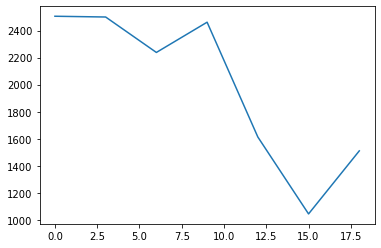

In [17]:
import matplotlib.pyplot as plt
df = ResultWriter.ChargingStationStates
df1 = df.loc[df.ChargingStationID == "chargingStation-1"]
#df1
fig = plt.plot(df1.BtmsPower + df1.TotalChargingPower)

In [18]:
df3 = ResultWriter.ChargingStationStates
df3.head(5)


,time,ChargingStationID,BaysVehicleIds,BaysChargingPower,TotalChargingPower,BaysChargingDesire,BaysNumberOfVehicles,QueueVehicleIds,QueueChargingDesire,QueueNumberOfVehicles,BtmsPower,BtmsSoc,BtmsEnergy,TotalChargingPowerDesire,GridPowerUpper,GridPowerLower
0,18463,chargingStation-1,"[5270466, 3256681, 1545605]","[0, 0, 174.49999999999997, 0, 0, 0, 0, 0, 0, 0...",174.5,"[inf, inf, 0.4034682080924855, nan, nan, nan, ...",3,[],[],0,2331.137605,0.577705,1444.261467,650.0,2505.637605,-2505.637605
1,18463,chargingStation-2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2500.000000,0.583333,1458.333333,0.0,2606.833978,-2606.833978
2,18463,chargingStation-3,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2500.000000,0.583333,1458.333333,0.0,2628.920163,-2628.920163
3,18763,chargingStation-1,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2500.000000,0.661038,1652.594800,0.0,2524.977341,-2524.977341
4,18763,chargingStation-2,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,[],[],0,2500.000000,0.666667,1666.666667,0.0,2544.311074,-2544.311074


In [19]:
df2=ResultWriter.Events
df2 = df2.loc[df2.ChargingStationId =='chargingStation-1']
df2.head(3)

,time,Event,ChargingStationId,VehicleId,QueueOrBay,ChargingDesire,VehicleType,VehicleArrival,VehicleDesiredEnd,VehicleEnergy,VehicleDesiredEnergy,VehicleSoc,VehicleMaxEnergy,VehicleMaxPower,ChargingBayMaxPower
0,18463,ArrivalEvent,chargingStation-1,5270466,,inf,ev-L1-0-to-50000-LowTech-2035-SUV-BEV_300_XFC,18163,18163,70.439238,70.439238,0.839023,83.953903,400.0,NaN
1,18463,ArrivalEvent,chargingStation-1,3256681,,inf,ev-L1-0-to-50000-LowTech-2035-Car-BEV_200,18406,18406,46.803395,46.803395,0.836234,55.969269,150.0,NaN
2,18463,ArrivalEvent,chargingStation-1,1545605,,0.403468,ev-L1-0-to-50000-LowTech-2035-Car-BEV_300_XFC,18633,18982,32.123079,46.664746,0.382628,83.953903,400.0,NaN


#### save results

In [20]:
ResultWriter.save()

#### plot results

(425.00000000000034, 2220.25)


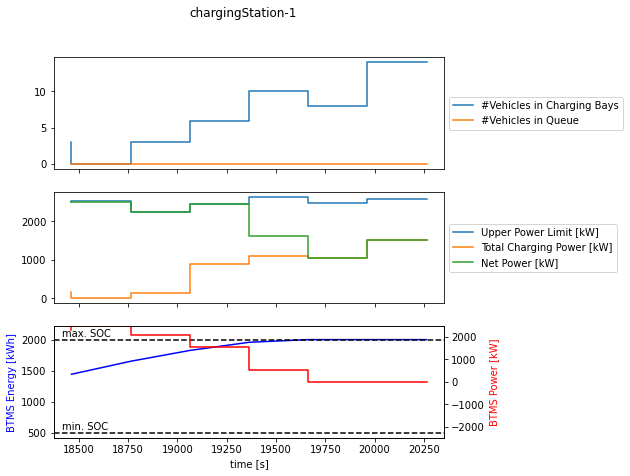

In [21]:
import matplotlib.pyplot as plt
loadDataFromFile = False
plotChargingStation = 0

if loadDataFromFile == True:
    pass
else:
    ChSt = ResultWriter.ChargingStationStates.loc[ResultWriter.ChargingStationStates.ChargingStationID == chargingStations[plotChargingStation].ChargingStationId]

fig, ax = plt.subplots(3,1, sharex=True)
fig.suptitle(chargingStations[plotChargingStation].ChargingStationId)
ax[0].step(ChSt.time, ChSt.BaysNumberOfVehicles, label = "#Vehicles in Charging Bays")
ax[0].step(ChSt.time, ChSt.QueueNumberOfVehicles, label = "#Vehicles in Queue")
ax[0].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[0].grid()

ax[1].step(ChSt.time, ChSt.GridPowerUpper, label = "Upper Power Limit [kW]")
ax[1].step(ChSt.time, ChSt.TotalChargingPower, label = "Total Charging Power [kW]")
ax[1].step(ChSt.time, ChSt.TotalChargingPower + ChSt.BtmsPower, label = "Net Power [kW]")
#ax[1].step(ChSt.time, ChSt.BtmsPower, label = "Net Power [kW]")
ax[1].legend(loc= 'center left', bbox_to_anchor=(1, 0.5))
#ax[1].grid()

ax[2].plot(ChSt.time, ChSt.BtmsEnergy, label = "BTMS Energy [kWh]", color = "blue")
ax[2].set_ylabel("BTMS Energy [kWh]", color = "blue")

y1=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMaxSoc
ax[2].axhline(y = y1, linestyle = "--", color ="black")

y2=chargingStations[plotChargingStation].BtmsSize*chargingStations[plotChargingStation].BtmsMinSoc
ax[2].axhline(y = y2, linestyle = "--", color ="black")
#ax[2].grid()

ylim = ax[2].get_ylim()
ax[2].set_ylim([ylim[0], 1.07*ylim[1]])
ylim = ax[2].get_ylim()
print(ylim)
dy = ylim[1]-ylim[0]
xlim = ax[2].get_xlim()
x = xlim[0]
dx = xlim[1]-xlim[0]
ax[2].text(x+0.02*dx, y1+0.03*dy, "max. SOC")
ax[2].text(x+0.02*dx, y2+0.03*dy, "min. SOC")

ax1 = ax[2].twinx()
ax1.step(ChSt.time, ChSt.BtmsPower, label = "BTMS Power [kW]", color = "red")
ax1.set_ylabel("BTMS Power [kW]", color = "red")
ax1.set_ylim([-chargingStations[plotChargingStation].GridPowerMax_Nom, chargingStations[plotChargingStation].GridPowerMax_Nom])

ax[2].set_xlabel("time [s]")

fig.set_size_inches(7, 7)
